# Asteroid Class Prediction Leveraging Parallelization Techniques 

<div style="text-align: right">  
<strong>Uday Kiran Dasari</strong>
</div>
<br/>
<center>
<img src="Asteroid.jpg" width=700 />
</center>
<br/>

**Link to Dataset used**: [**Asteroid Dataset**](https://www.kaggle.com/datasets/sakhawat18/asteroid-dataset/data)

### Dataset Description

- **SPK-ID:** Object primary SPK-ID
- **Object ID:** Object internal database ID
- **Object fullname:** Object full name/designation
- **pdes:** Object primary designation
- **name:** Object IAU name
- **NEO:** Near-Earth Object (NEO) flag
- **PHA:** Potentially Hazardous Asteroid (PHA) flag
- **H:** Absolute magnitude parameter
- **Diameter:** Object diameter (from equivalent sphere) km Unit
- **Albedo:** Geometric albedo
- **Diameter_sigma:** 1-sigma uncertainty in object diameter km Unit
- **Orbit_id:** Orbit solution ID
- **Epoch:** Epoch of osculation in modified Julian day form
- **Equinox:** Equinox of reference frame
- **e:** Eccentricity
- **a:** Semi-major axis au Unit
- **q:** Perihelion distance au Unit
- **i:** Inclination; angle with respect to x-y ecliptic plane
- **tp:** Time of perihelion passage TDB Unit
- **moid_ld:** Earth Minimum Orbit Intersection Distance au Unit
-y ecliptic plane

### Necessary Libraries

In [1]:
# Basic imports
import joblib
import numpy as np
import pandas as pd
import time
import multiprocessing

# Visualization imports
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn imports
from sklearn.ensemble import ExtraTreesClassifier
#from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder

# Dask-related imports
import dask
import dask.array as da
import dask.dataframe as dd
from dask_ml.impute import SimpleImputer
from dask.distributed import Client, config
from dask.diagnostics import ProgressBar
from dask_ml.model_selection import GridSearchCV,train_test_split

# Set the daemon configuration for Dask workers
dask.config.set({'distributed.worker.daemon': False})

# XGBoost and Dask-XGBoost
import xgboost as xgb
from xgboost import dask as dxgb

import warnings
warnings.filterwarnings('ignore', category=UserWarning)

# Inline matplotlib setup
%matplotlib inline

## Data Preprocessing

### Loading the dataset

In [2]:
%%time
# Load the dataset with specified data types
astro_ds = dd.read_csv('./dataset.csv')

CPU times: user 28.7 ms, sys: 5.82 ms, total: 34.5 ms
Wall time: 36.3 ms


In [3]:
# Check data types and info
print(astro_ds.dtypes)
astro_ds.head()

id                string[pyarrow]
spkid                       int64
full_name         string[pyarrow]
pdes                        int64
name              string[pyarrow]
prefix                    float64
neo               string[pyarrow]
pha               string[pyarrow]
H                         float64
diameter                  float64
albedo                    float64
diameter_sigma            float64
orbit_id          string[pyarrow]
epoch                     float64
epoch_mjd                   int64
epoch_cal                 float64
equinox           string[pyarrow]
e                         float64
a                         float64
q                         float64
i                         float64
om                        float64
w                         float64
ma                        float64
ad                        float64
n                         float64
tp                        float64
tp_cal                    float64
per                       float64
per_y         

,id,spkid,full_name,pdes,name,prefix,neo,pha,H,diameter,...,sigma_i,sigma_om,sigma_w,sigma_ma,sigma_ad,sigma_n,sigma_tp,sigma_per,class,rms
0,a0000001,2000001,1 Ceres,1,Ceres,NaN,N,N,3.40,939.400,...,4.608900e-09,6.168800e-08,6.624800e-08,7.820700e-09,1.111300e-11,1.196500e-12,3.782900e-08,9.415900e-09,MBA,0.43301
1,a0000002,2000002,2 Pallas,2,Pallas,NaN,N,N,4.20,545.000,...,3.469400e-06,6.272400e-06,9.128200e-06,8.859100e-06,4.961300e-09,4.653600e-10,4.078700e-05,3.680700e-06,MBA,0.35936
2,a0000003,2000003,3 Juno,3,Juno,NaN,N,N,5.33,246.596,...,3.223100e-06,1.664600e-05,1.772100e-05,8.110400e-06,4.363900e-09,4.413400e-10,3.528800e-05,3.107200e-06,MBA,0.33848
3,a0000004,2000004,4 Vesta,4,Vesta,NaN,N,N,3.00,525.400,...,2.170600e-07,3.880800e-07,1.789300e-07,1.206800e-06,1.648600e-09,2.612500e-10,4.103700e-06,1.274900e-06,MBA,0.39980
4,a0000005,2000005,5 Astraea,5,Astraea,NaN,N,N,6.90,106.699,...,2.740800e-06,2.894900e-05,2.984200e-05,8.303800e-06,4.729000e-09,5.522700e-10,3.474300e-05,3.490500e-06,MBA,0.52191


In [4]:
# Drop columns early in the process
columns_to_drop = ['id', 'full_name', 'pdes', 'name', 'prefix', 'neo', 'pha', 'orbit_id', 'equinox']
astro_ds = astro_ds.drop(columns_to_drop, axis=1)
astro_ds.head()

,spkid,H,diameter,albedo,diameter_sigma,epoch,epoch_mjd,epoch_cal,e,a,...,sigma_i,sigma_om,sigma_w,sigma_ma,sigma_ad,sigma_n,sigma_tp,sigma_per,class,rms
0,2000001,3.40,939.400,0.0900,0.200,2458600.5,58600,20190427.0,0.076009,2.769165,...,4.608900e-09,6.168800e-08,6.624800e-08,7.820700e-09,1.111300e-11,1.196500e-12,3.782900e-08,9.415900e-09,MBA,0.43301
1,2000002,4.20,545.000,0.1010,18.000,2459000.5,59000,20200531.0,0.229972,2.773841,...,3.469400e-06,6.272400e-06,9.128200e-06,8.859100e-06,4.961300e-09,4.653600e-10,4.078700e-05,3.680700e-06,MBA,0.35936
2,2000003,5.33,246.596,0.2140,10.594,2459000.5,59000,20200531.0,0.256936,2.668285,...,3.223100e-06,1.664600e-05,1.772100e-05,8.110400e-06,4.363900e-09,4.413400e-10,3.528800e-05,3.107200e-06,MBA,0.33848
3,2000004,3.00,525.400,0.4228,0.200,2458600.5,58600,20190427.0,0.088721,2.361418,...,2.170600e-07,3.880800e-07,1.789300e-07,1.206800e-06,1.648600e-09,2.612500e-10,4.103700e-06,1.274900e-06,MBA,0.39980
4,2000005,6.90,106.699,0.2740,3.140,2459000.5,59000,20200531.0,0.190913,2.574037,...,2.740800e-06,2.894900e-05,2.984200e-05,8.303800e-06,4.729000e-09,5.522700e-10,3.474300e-05,3.490500e-06,MBA,0.52191


In [5]:
astro_ds.describe().compute()

,spkid,H,diameter,albedo,diameter_sigma,epoch,epoch_mjd,epoch_cal,e,a,...,sigma_q,sigma_i,sigma_om,sigma_w,sigma_ma,sigma_ad,sigma_n,sigma_tp,sigma_per,rms
count,9.585240e+05,952261.000000,136209.000000,135103.000000,136081.000000,9.585240e+05,958524.000000,9.585240e+05,958524.000000,958524.000000,...,9.386020e+05,9.386020e+05,9.386020e+05,9.386020e+05,9.386020e+05,9.385980e+05,9.386020e+05,9.386020e+05,9.385980e+05,958522.000000
mean,3.810114e+06,16.906411,5.506429,0.130627,0.479184,2.458869e+06,58868.781950,2.019693e+07,0.156116,2.902143,...,1.982929e+01,1.168449e+00,5.310234e+00,1.370062e+06,1.369977e+06,2.131453e+01,5.060221e-02,4.312780e+08,8.525815e+04,0.561153
std,6.831541e+06,1.790405,9.425164,0.110323,0.782895,7.016716e+02,701.671573,1.930354e+04,0.092643,39.719503,...,2.903785e+03,1.282231e+02,1.333381e+03,9.158996e+08,9.158991e+08,7.197034e+03,9.814953e+00,2.953046e+11,2.767681e+07,2.745700
min,2.000001e+06,-1.100000,0.002500,0.001000,0.000500,2.425052e+06,25051.000000,1.927062e+07,0.000000,-14702.447872,...,1.956900e-11,4.608900e-09,6.168800e-08,6.624800e-08,7.820700e-09,1.111300e-11,1.196500e-12,3.782900e-08,9.415900e-09,0.000000
25%,2.234853e+06,16.500000,3.174000,0.069000,0.257000,2.459000e+06,59000.000000,2.020053e+07,0.101109,2.419544,...,1.465500e-07,6.123925e-06,5.050300e-05,6.537500e-05,3.093900e-05,2.331700e-08,3.008025e-09,1.342400e-04,1.815800e-05,0.545030
50%,2.472890e+06,17.300000,4.649000,0.102000,0.487000,2.459000e+06,59000.000000,2.020053e+07,0.163274,2.675917,...,2.977450e-07,1.032100e-05,9.441200e-05,1.272275e-04,6.443200e-05,6.726850e-08,6.711900e-09,2.941000e-04,5.373900e-05,0.582160
75%,3.762552e+06,18.618000,6.201000,0.188000,0.812000,2.459000e+06,59000.000000,2.020053e+07,0.228230,3.041111,...,9.311900e-05,1.006100e-03,1.334400e-03,1.325300e-02,2.569900e-02,1.603500e-04,2.676450e-06,8.251200e-02,1.153200e-01,0.635050
max,5.401723e+07,33.200000,939.400000,1.000000,140.000000,2.459000e+06,59000.000000,2.020053e+07,1.855356,33488.895955,...,1.015000e+06,5.533000e+04,1.199100e+06,8.845100e+11,8.845100e+11,5.509700e+06,7.698800e+03,2.853100e+14,1.910700e+10,2686.600000


In [6]:
astro_ds.isnull().sum().compute()

spkid                  0
H                   6263
diameter          822315
albedo            823421
diameter_sigma    822443
epoch                  0
epoch_mjd              0
epoch_cal              0
e                      0
a                      0
q                      0
i                      0
om                     0
w                      0
ma                     1
ad                     4
n                      0
tp                     0
tp_cal                 0
per                    4
per_y                  1
moid               19921
moid_ld              127
sigma_e            19922
sigma_a            19922
sigma_q            19922
sigma_i            19922
sigma_om           19922
sigma_w            19922
sigma_ma           19922
sigma_ad           19926
sigma_n            19922
sigma_tp           19922
sigma_per          19926
class                  0
rms                    2
dtype: int64

**Filling the null values using Dask Simple Imputer**

In [7]:
# Prepare features for imputation (excluding the target 'class')
X = astro_ds.drop(['class'], axis=1)
y = astro_ds['class']

In [8]:
# Applying SimpleImputer from Dask-ML to handle missing values in parallel
imputer = SimpleImputer(strategy='median')

# Since Dask works with lazy evaluation, use compute() to perform the computation
X_imputed = imputer.fit_transform(X)

In [9]:
# Ensure that imputation and other transformations are computed efficiently
with ProgressBar():
    X_imputed = X_imputed.compute()  # This will trigger the actual computation
    y = y.compute()  # Ensure the target variable is also ready for model training

[########################################] | 100% Completed | 1.45 ss
[########################################] | 100% Completed | 850.57 ms


### Feature Importances

In [10]:
%%time
# Split data into training and test sets (consider doing this before imputation if you want a more rigorous evaluation)
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2,shuffle =True ,random_state=42)

# Initialize the ExtraTreesClassifier
# Note: You can adjust n_estimators, max_depth, and other parameters as needed
etc = ExtraTreesClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# To leverage parallel computation with Dask when performing model fitting
with joblib.parallel_backend('multiprocessing'):
    # Fit the model
    etc.fit(X_train, y_train)

CPU times: user 2.87 s, sys: 1.72 s, total: 4.58 s
Wall time: 10.2 s


#### Visualizing the feature importances

Feature importances:
spkid: 0.00385
H: 0.04009
diameter: 0.00133
albedo: 0.00177
diameter_sigma: 0.00093
epoch: 0.00234
epoch_mjd: 0.00255
epoch_cal: 0.00275
e: 0.07411
a: 0.09232
q: 0.12400
i: 0.03087
om: 0.00209
w: 0.00265
ma: 0.00333
ad: 0.05627
n: 0.14841
tp: 0.00530
tp_cal: 0.00540
per: 0.09265
per_y: 0.08823
moid: 0.11557
moid_ld: 0.08445
sigma_e: 0.00127
sigma_a: 0.00125
sigma_q: 0.00154
sigma_i: 0.00162
sigma_om: 0.00159
sigma_w: 0.00154
sigma_ma: 0.00157
sigma_ad: 0.00129
sigma_n: 0.00109
sigma_tp: 0.00155
sigma_per: 0.00191
rms: 0.00254


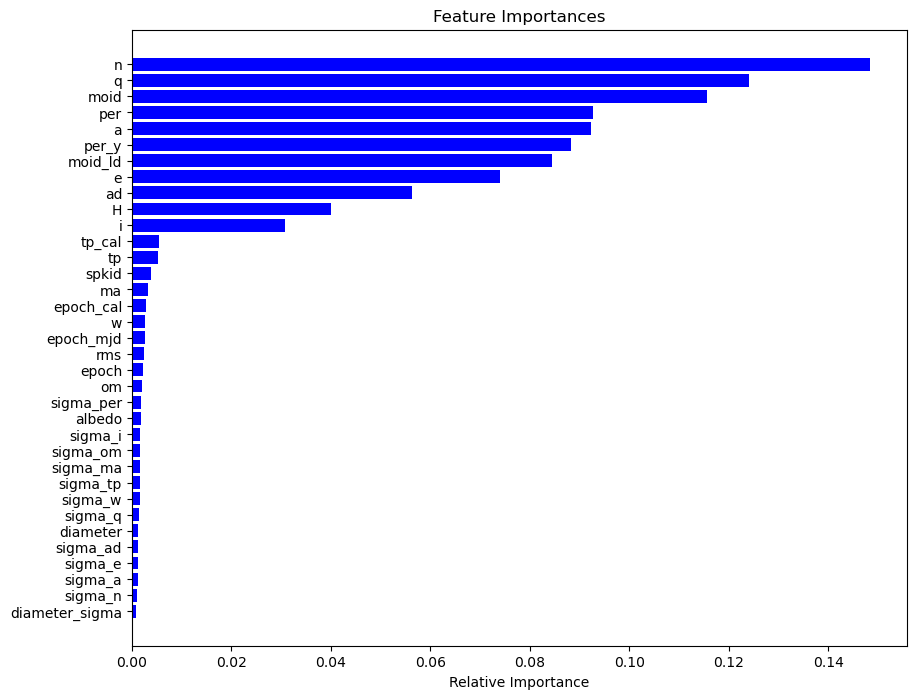

In [11]:
# Compute and print feature importances
feature_importances = etc.feature_importances_

# Create a dictionary to hold feature names and their importance values
features = X_train.columns
feature_importance_dict = dict(zip(features, feature_importances))

# Print feature importances along with their names
print("Feature importances:")
for feature, importance in feature_importance_dict.items():
    print(f"{feature}: {importance:.5f}")

# Visualize the feature importance
plt.figure(figsize=(10, 8))
indices = np.argsort(feature_importances)
plt.title('Feature Importances')
plt.barh(range(len(indices)), feature_importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [12]:
threshold = np.mean(feature_importances)  # Define your threshold here

# Selecting features with importance greater than the threshold
selected_features = [feature for feature, importance in zip(X_train.columns, feature_importances) if importance > threshold]

print("Selected features:", selected_features)

Selected features: ['H', 'e', 'a', 'q', 'i', 'ad', 'n', 'per', 'per_y', 'moid', 'moid_ld']


In [13]:
# Include 'class' in selected features
selected_features.append('class')

# Filter the original Dask DataFrame to include only selected features
astro_ds_filtered = astro_ds[selected_features]

In [14]:
astro_ds_filtered.isnull().sum().compute()

H           6263
e              0
a              0
q              0
i              0
ad             4
n              0
per            4
per_y          1
moid       19921
moid_ld      127
class          0
dtype: int64

In [15]:
# Prepare features for imputation (excluding the target 'class')
X = astro_ds_filtered.drop(['class'], axis=1)
y = astro_ds_filtered['class']

In [16]:
# Applying SimpleImputer from Dask-ML to handle missing values in parallel
imputer = SimpleImputer(strategy='median')

# Since Dask works with lazy evaluation, use compute() to perform the computation
X_imputed = imputer.fit_transform(X)

In [17]:
# Ensure that imputation and other transformations are computed efficiently
with ProgressBar():
    X_imputed = X_imputed.compute()  # This will trigger the actual computation
    y = y.compute()  # Ensure the target variable is also ready for model training

[########################################] | 100% Completed | 948.34 ms
[########################################] | 100% Completed | 894.59 ms


In [18]:
X_imputed.isnull().sum()

H          0
e          0
a          0
q          0
i          0
ad         0
n          0
per        0
per_y      0
moid       0
moid_ld    0
dtype: int64

In [19]:
y.unique()

array(['MBA', 'OMB', 'MCA', 'AMO', 'IMB', 'TJN', 'CEN', 'APO', 'ATE',
       'AST', 'TNO', 'IEO', 'HYA'], dtype=object)

### Test Train Split

In [20]:
# Split the data into training and test sets
#from dask_ml.model_selection import GridSearchCV,train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2,shuffle=True, random_state=42)

In [21]:
type(X_train),type(X_test),type(y_train),type(y_test)

(pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame,
 pandas.core.series.Series,
 pandas.core.series.Series)

In [22]:
# Scaling the data using Dask-ML's StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [23]:
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)

In [24]:
type(X_train_scaled),type(X_test_scaled),type(y_train_encoded),type(y_test_encoded)

(numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray)

In [25]:
X_train_scaled.shape,X_test_scaled.shape,y_train_encoded.shape,y_test_encoded.shape

((766819, 11), (191705, 11), (766819,), (191705,))

In [26]:
# If these are pandas DataFrame, convert them to Dask DataFrame
#X_train, y_train, X_test, y_test = dd.from_pandas(X_train), dd.from_pandas(y_train), dd.from_pandas(X_test), dd.from_pandas(y_test)

In [27]:
X_train.shape

(766819, 11)

## XG Boost

### Model Training and Hyper parameter tuning

In [28]:
# Convert training and testing data into Dask Arrays
X_train_dask = da.from_array(X_train_scaled, chunks=(20000, X_train.shape[1]))
y_train_dask = da.from_array(y_train_encoded, chunks=20000)
X_test_dask = da.from_array(X_test_scaled, chunks=(20000, X_test.shape[1]))
y_test_dask = da.from_array(y_test_encoded, chunks=20000)

Dask Dashboard URL for 4 CPUs: http://127.0.0.1:37536/status


[23:41:34] task [xgboost.dask-0]:tcp://127.0.0.1:36723 got new rank 0
[23:41:34] task [xgboost.dask-1]:tcp://127.0.0.1:46397 got new rank 1
[23:41:34] task [xgboost.dask-2]:tcp://127.0.0.1:43432 got new rank 2
[23:41:34] task [xgboost.dask-3]:tcp://127.0.0.1:43147 got new rank 3


[0]	train-mlogloss:1.93967
[1]	train-mlogloss:1.60887
[2]	train-mlogloss:1.37576
[3]	train-mlogloss:1.19570
[4]	train-mlogloss:1.04988
[5]	train-mlogloss:0.92830
[6]	train-mlogloss:0.82495
[7]	train-mlogloss:0.73588
[8]	train-mlogloss:0.65835
[9]	train-mlogloss:0.59035
[10]	train-mlogloss:0.53037
[11]	train-mlogloss:0.47723
[12]	train-mlogloss:0.42995
[13]	train-mlogloss:0.38780
[14]	train-mlogloss:0.35011
[15]	train-mlogloss:0.31636
[16]	train-mlogloss:0.28608
[17]	train-mlogloss:0.25888
[18]	train-mlogloss:0.23442
[19]	train-mlogloss:0.21240
[20]	train-mlogloss:0.19257
[21]	train-mlogloss:0.17469
[22]	train-mlogloss:0.15856
[23]	train-mlogloss:0.14401
[24]	train-mlogloss:0.13087
[25]	train-mlogloss:0.11901
[26]	train-mlogloss:0.10829
[27]	train-mlogloss:0.09860
[28]	train-mlogloss:0.08985
[29]	train-mlogloss:0.08193
[30]	train-mlogloss:0.07477
[31]	train-mlogloss:0.06829
[32]	train-mlogloss:0.06243
[33]	train-mlogloss:0.05713
[34]	train-mlogloss:0.05234
[35]	train-mlogloss:0.04799
[3

[23:42:17] task [xgboost.dask-0]:tcp://127.0.0.1:33363 got new rank 0
[23:42:17] task [xgboost.dask-1]:tcp://127.0.0.1:40689 got new rank 1
[23:42:17] task [xgboost.dask-2]:tcp://127.0.0.1:42832 got new rank 2
[23:42:17] task [xgboost.dask-3]:tcp://127.0.0.1:45874 got new rank 3
[23:42:17] task [xgboost.dask-4]:tcp://127.0.0.1:36664 got new rank 4
[23:42:17] task [xgboost.dask-5]:tcp://127.0.0.1:33656 got new rank 5
[23:42:17] task [xgboost.dask-6]:tcp://127.0.0.1:43023 got new rank 6
[23:42:17] task [xgboost.dask-7]:tcp://127.0.0.1:33814 got new rank 7


[0]	train-mlogloss:1.93958
[1]	train-mlogloss:1.60875
[2]	train-mlogloss:1.37560
[3]	train-mlogloss:1.19553
[4]	train-mlogloss:1.04971
[5]	train-mlogloss:0.92810
[6]	train-mlogloss:0.82474
[7]	train-mlogloss:0.73566
[8]	train-mlogloss:0.65810
[9]	train-mlogloss:0.59010
[10]	train-mlogloss:0.53011
[11]	train-mlogloss:0.47696
[12]	train-mlogloss:0.42969
[13]	train-mlogloss:0.38753
[14]	train-mlogloss:0.34984
[15]	train-mlogloss:0.31608
[16]	train-mlogloss:0.28580
[17]	train-mlogloss:0.25860
[18]	train-mlogloss:0.23413
[19]	train-mlogloss:0.21212
[20]	train-mlogloss:0.19229
[21]	train-mlogloss:0.17440
[22]	train-mlogloss:0.15828
[23]	train-mlogloss:0.14372
[24]	train-mlogloss:0.13059
[25]	train-mlogloss:0.11872
[26]	train-mlogloss:0.10800
[27]	train-mlogloss:0.09832
[28]	train-mlogloss:0.08957
[29]	train-mlogloss:0.08166
[30]	train-mlogloss:0.07449
[31]	train-mlogloss:0.06802
[32]	train-mlogloss:0.06217
[33]	train-mlogloss:0.05687
[34]	train-mlogloss:0.05208
[35]	train-mlogloss:0.04774
[3

[23:42:50] task [xgboost.dask-0]:tcp://127.0.0.1:45223 got new rank 0
[23:42:50] task [xgboost.dask-10]:tcp://127.0.0.1:45644 got new rank 1
[23:42:50] task [xgboost.dask-11]:tcp://127.0.0.1:38048 got new rank 2
[23:42:51] task [xgboost.dask-12]:tcp://127.0.0.1:43339 got new rank 3
[23:42:51] task [xgboost.dask-13]:tcp://127.0.0.1:37453 got new rank 4
[23:42:51] task [xgboost.dask-14]:tcp://127.0.0.1:37778 got new rank 5
[23:42:51] task [xgboost.dask-15]:tcp://127.0.0.1:35955 got new rank 6
[23:42:51] task [xgboost.dask-1]:tcp://127.0.0.1:35193 got new rank 7
[23:42:51] task [xgboost.dask-2]:tcp://127.0.0.1:38837 got new rank 8
[23:42:51] task [xgboost.dask-3]:tcp://127.0.0.1:41492 got new rank 9
[23:42:51] task [xgboost.dask-4]:tcp://127.0.0.1:38275 got new rank 10
[23:42:51] task [xgboost.dask-5]:tcp://127.0.0.1:35612 got new rank 11
[23:42:51] task [xgboost.dask-6]:tcp://127.0.0.1:42809 got new rank 12
[23:42:51] task [xgboost.dask-7]:tcp://127.0.0.1:39133 got new rank 13
[23:42:51]

[0]	train-mlogloss:1.94053
[1]	train-mlogloss:1.61004
[2]	train-mlogloss:1.37710
[3]	train-mlogloss:1.19718
[4]	train-mlogloss:1.05146
[5]	train-mlogloss:0.92996
[6]	train-mlogloss:0.82667
[7]	train-mlogloss:0.73766
[8]	train-mlogloss:0.66017
[9]	train-mlogloss:0.59221
[10]	train-mlogloss:0.53226
[11]	train-mlogloss:0.47913
[12]	train-mlogloss:0.43187
[13]	train-mlogloss:0.38973
[14]	train-mlogloss:0.35205
[15]	train-mlogloss:0.31830
[16]	train-mlogloss:0.28801
[17]	train-mlogloss:0.26081
[18]	train-mlogloss:0.23635
[19]	train-mlogloss:0.21432
[20]	train-mlogloss:0.19448
[21]	train-mlogloss:0.17660
[22]	train-mlogloss:0.16048
[23]	train-mlogloss:0.14592
[24]	train-mlogloss:0.13278
[25]	train-mlogloss:0.12092
[26]	train-mlogloss:0.11019
[27]	train-mlogloss:0.10050
[28]	train-mlogloss:0.09173
[29]	train-mlogloss:0.08379
[30]	train-mlogloss:0.07663
[31]	train-mlogloss:0.07014
[32]	train-mlogloss:0.06426
[33]	train-mlogloss:0.05894
[34]	train-mlogloss:0.05413
[35]	train-mlogloss:0.04977
[3

[23:43:21] task [xgboost.dask-0]:tcp://127.0.0.1:42040 got new rank 0
[23:43:21] task [xgboost.dask-10]:tcp://127.0.0.1:35982 got new rank 1
[23:43:22] task [xgboost.dask-11]:tcp://127.0.0.1:34600 got new rank 2
[23:43:22] task [xgboost.dask-12]:tcp://127.0.0.1:46203 got new rank 3
[23:43:22] task [xgboost.dask-13]:tcp://127.0.0.1:43650 got new rank 4
[23:43:22] task [xgboost.dask-14]:tcp://127.0.0.1:36238 got new rank 5
[23:43:22] task [xgboost.dask-15]:tcp://127.0.0.1:35800 got new rank 6
[23:43:22] task [xgboost.dask-16]:tcp://127.0.0.1:36356 got new rank 7
[23:43:22] task [xgboost.dask-17]:tcp://127.0.0.1:44957 got new rank 8
[23:43:22] task [xgboost.dask-18]:tcp://127.0.0.1:44184 got new rank 9
[23:43:22] task [xgboost.dask-19]:tcp://127.0.0.1:42763 got new rank 10
[23:43:22] task [xgboost.dask-1]:tcp://127.0.0.1:45068 got new rank 11
[23:43:22] task [xgboost.dask-2]:tcp://127.0.0.1:36021 got new rank 12
[23:43:22] task [xgboost.dask-3]:tcp://127.0.0.1:39739 got new rank 13
[23:43

[0]	train-mlogloss:1.94026
[1]	train-mlogloss:1.60967
[2]	train-mlogloss:1.37668
[3]	train-mlogloss:1.19671
[4]	train-mlogloss:1.05096
[5]	train-mlogloss:0.92943
[6]	train-mlogloss:0.82613
[7]	train-mlogloss:0.73710
[8]	train-mlogloss:0.65960
[9]	train-mlogloss:0.59164
[10]	train-mlogloss:0.53168
[11]	train-mlogloss:0.47856
[12]	train-mlogloss:0.43131
[13]	train-mlogloss:0.38916
[14]	train-mlogloss:0.35148
[15]	train-mlogloss:0.31773
[16]	train-mlogloss:0.28745
[17]	train-mlogloss:0.26025
[18]	train-mlogloss:0.23579
[19]	train-mlogloss:0.21378
[20]	train-mlogloss:0.19395
[21]	train-mlogloss:0.17607
[22]	train-mlogloss:0.15994
[23]	train-mlogloss:0.14539
[24]	train-mlogloss:0.13225
[25]	train-mlogloss:0.12039
[26]	train-mlogloss:0.10967
[27]	train-mlogloss:0.09998
[28]	train-mlogloss:0.09123
[29]	train-mlogloss:0.08331
[30]	train-mlogloss:0.07614
[31]	train-mlogloss:0.06965
[32]	train-mlogloss:0.06380
[33]	train-mlogloss:0.05848
[34]	train-mlogloss:0.05368
[35]	train-mlogloss:0.04933
[3

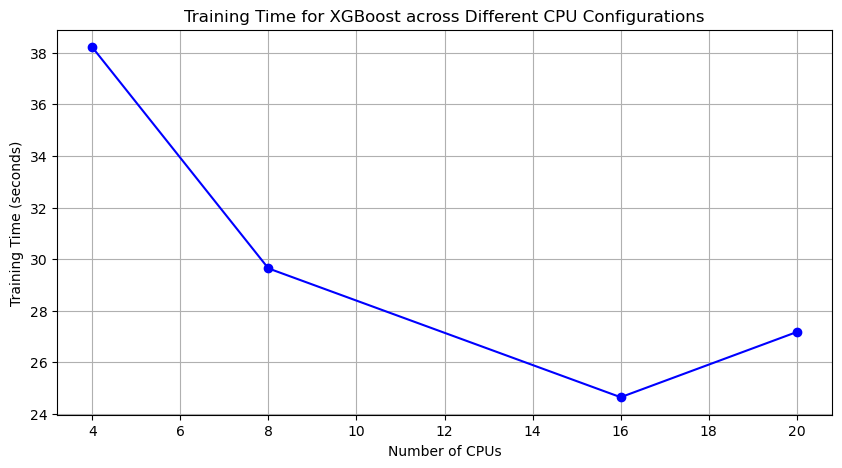

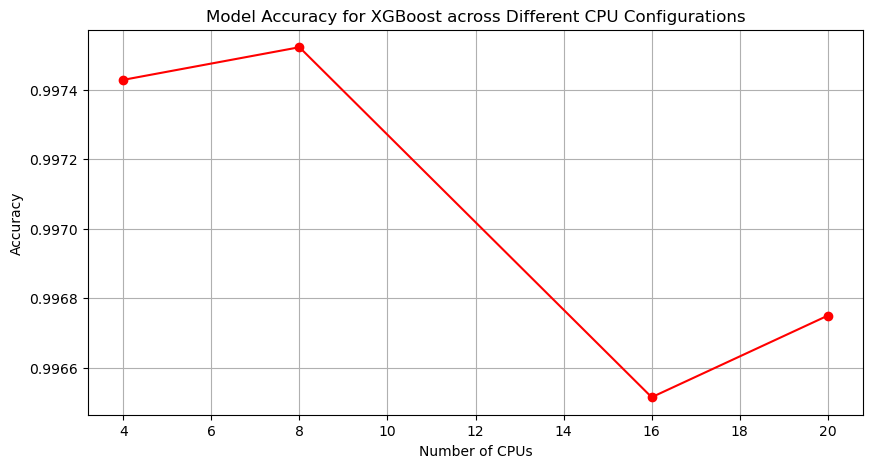

In [29]:
import xgboost as xgb
import dask.array as da
import dask.distributed
from dask.distributed import Client, LocalCluster
import dask.array as da
import time
import matplotlib.pyplot as plt
from dask.array import argmax
from sklearn.metrics import accuracy_score
import seaborn as sns

def evaluate_xgb_with_daskmatrix_futures(X_train, y_train, X_test, y_test, cpu_configs):
    results = {}

    # Convert training and testing data into Dask Arrays
    X_train_dask = da.from_array(X_train_scaled, chunks=(20000, X_train.shape[1]))
    y_train_dask = da.from_array(y_train_encoded, chunks=20000)
    X_test_dask = da.from_array(X_test_scaled, chunks=(20000, X_test.shape[1]))
    y_test_dask = da.from_array(y_test_encoded, chunks=20000)

    for cpus in cpu_configs:
        if 'client' in locals():
            client.close()
        cluster = LocalCluster(n_workers=cpus, threads_per_worker=1)
        client = Client(cluster)
        print(f"Dask Dashboard URL for {cpus} CPUs: {client.dashboard_link}")

        # Creating DaskDMatrix objects
        dtrain = xgb.dask.DaskDMatrix(client, X_train_dask, y_train_dask)
        dtest = xgb.dask.DaskDMatrix(client, X_test_dask, y_test_dask)

        params = {
            'objective': 'multi:softprob',
            'num_class': 13,
            'max_depth': 6,
            'learning_rate': 0.1,
            'tree_method': 'hist',
        }

        # Training the model using Dask futures
        start_time = time.time()
        output = xgb.dask.train(client,params,dtrain,num_boost_round=100,evals=[(dtrain, "train")])
        end_time = time.time()
        print(f"Time taken for Dask XGB on {cpus}:{end_time-start_time}seconds")
        # Access the trained booster
        bst = output['booster']

        # Making predictions
        prediction = xgb.dask.predict(client, bst, dtest)
        predictions = prediction.compute()
        predictions = predictions.argmax(axis=1)  # Convert probability predictions to class labels
        accuracy = accuracy_score(y_test_dask.compute(), predictions)

        # Record results
        results[cpus] = {
            'Training Time': end_time - start_time,
            'Accuracy': accuracy
        }

        client.close()

    # Plotting results
    cpus_list = list(results.keys())
    training_times = [results[cpus]['Training Time'] for cpus in cpus_list]
    accuracies = [results[cpus]['Accuracy'] for cpus in cpus_list]

    plt.figure(figsize=(10, 5))
    plt.plot(cpus_list, training_times, marker='o', linestyle='-', color='b')
    plt.title('Training Time for XGBoost across Different CPU Configurations')
    plt.xlabel('Number of CPUs')
    plt.ylabel('Training Time (seconds)')
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(cpus_list, accuracies, marker='o', linestyle='-', color='r')
    plt.title('Model Accuracy for XGBoost across Different CPU Configurations')
    plt.xlabel('Number of CPUs')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.show()

    return results


cpu_configs = [4, 8,16,20]
results_xgb = evaluate_xgb_with_daskmatrix_futures(X_train, y_train, X_test, y_test, cpu_configs)